In [1]:
# solve the waterfilling problem with one type in 1D, with correct units
# 1) compute normalized spatial spectrum of van Hateren image database (in cycles per pixel)
# 2) choose a number of neurons
# 3) compute corresponding mask (k tild business)
# 4) solve water-filling with this mask (obj = VarExpl - FiringRate)
# 5) iterate over number of neurons to find sweet spot

# => SWEET SPOT FOUND!!
# NEXT in C6: TWO TYPES!

#Is there a benefit of having two types compared to one type
# steps
# 1) perform grid search over one type
# 2) perform grid serach over two types
# 3) conclude

# Bonus: Is there mode sharing between the two types?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import trange


%matplotlib inline

sess = tf.Session()

In [3]:
# load images fro the Van Hateren DB
Is = np.load('Is.npy')

Is.shape

(101, 768, 1024)

In [4]:
# compute the 1D spectrum of images that are luminance and contrast normalized

#for lim in range(300,1000,100):
lim = 300

pwrs = list()
for im in Is:
    for l in range(10,760,2):
        line = im[l,:lim]
        line = (line - np.mean(line))/np.std(line)
        pwrs.append(np.abs(np.fft.rfft(line, norm = 'ortho'))**2)

pwrs = np.array(pwrs)
S = np.mean(pwrs,axis =0)
S = S[1:]
#S = S/S[0]
#plt.plot(np.linspace(0,1,len(S)-1),np.log(S[1:]))


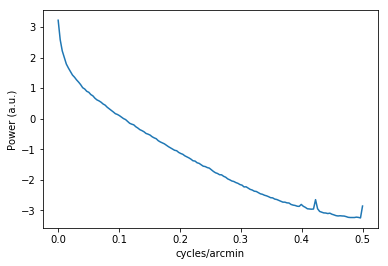

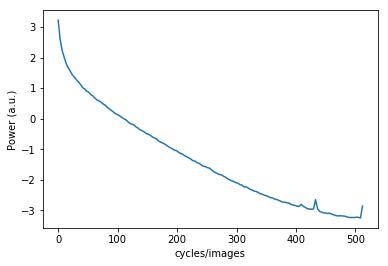

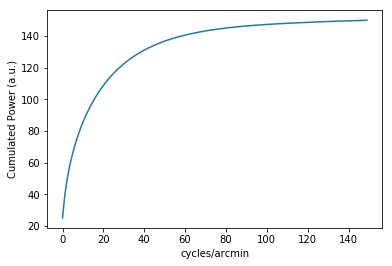

In [5]:
# Show spectrum in real units of viewing (look up daytime luminance)

plt.figure()
plt.plot(np.linspace(0,0.5,len(S)),np.log(S))
plt.xlabel('cycles/arcmin')
plt.ylabel('Power (a.u.)')

plt.figure()
plt.plot(np.linspace(0,1024/2,len(S)),np.log(S))
plt.xlabel('cycles/images')
plt.ylabel('Power (a.u.)')

plt.figure()
plt.plot(np.cumsum(S))
plt.xlabel('cycles/arcmin')
plt.ylabel('Cumulated Power (a.u.)')

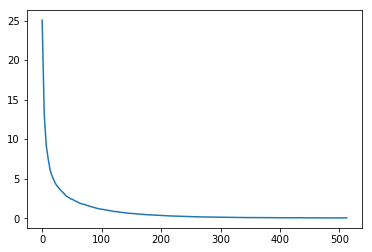

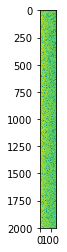

In [6]:
# Generate pink noise DATASET

NSAMPLES = 2000
NFREQ = len(S)

Ks = np.linspace(0,1024/2,len(S)) # in cycles/image
dk = np.mean(np.diff(Ks))

# signal
X = np.random.randn(NSAMPLES,NFREQ)*np.sqrt(S)

plt.figure()
plt.plot(Ks,S)

plt.figure()
plt.imshow(np.log(X**2))

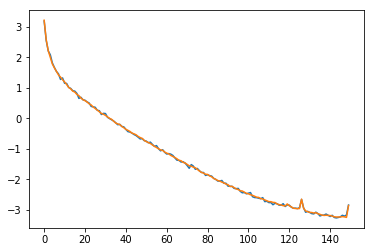

In [7]:
# Check that the signal has variance equal to Power

Semp = np.mean(X**2,axis = 0)

plt.plot(np.log(Semp))
plt.plot(np.log(S))

In [8]:
# For a number of neurons, compute the correspoding mask of Ks vs Ktild

def create_mask(NCELLS):
    skip = int(NCELLS/(dk))

    NFREQ_NEURAL = skip

    mask = np.zeros((NFREQ,NFREQ_NEURAL))


    for freqn in range(NFREQ_NEURAL):
        pointer = freqn
        while pointer < len(Ks):
            mask[pointer,freqn] = 1
            pointer += skip
            
    return mask,NFREQ_NEURAL

    #plt.imshow(mask,aspect = 'auto')
    #print(np.sum(mask), NFREQ, NFREQ_NEURAL)

In [9]:
# define noise

def generate_noise(varNoise, NFREQ_NEURAL, NCELLS):
    N = np.sqrt(varNoise)/NFREQ_NEURAL*NCELLS*np.random.randn(NSAMPLES,NFREQ_NEURAL)
    return N



In [29]:
# Set parameters (noise, threshold on total firing rate)

varNoise = 1 # noise per cell
L1 = 32 # Firing rate per cell


In [31]:
30/500

0.06

In [32]:
grid = range(0,500,30)
NG = len(grid)

VarExpls = np.zeros((NG,NG))

for i1 in range(NG):
    for i2 in range(i1,NG):
        NCELLS_1 = grid[i1]
        NCELLS_2 = grid[i2]

        MASK_1,NFREQ_NEURAL_1 = create_mask(NCELLS_1)
        MASK_2,NFREQ_NEURAL_2 = create_mask(NCELLS_2)

        NFREQ_NEURAL = NFREQ_NEURAL_1+NFREQ_NEURAL_2
        NCELLS = NCELLS_1 + NCELLS_2

        NOISE = np.sqrt(varNoise)/(NFREQ_NEURAL)*NCELLS*np.random.randn(NSAMPLES,NFREQ_NEURAL)

        # data in tensorflow
        _X = tf.constant(X, dtype=tf.float32)
        _NOISE = tf.constant(NOISE, dtype=tf.float32)

        _MASK_1 = tf.constant(MASK_1, dtype=tf.float32)
        _MASK_2 = tf.constant(MASK_2, dtype=tf.float32)


        # weights
        _W1 = tf.Variable(np.random.randn(NFREQ, NFREQ_NEURAL_1), dtype=tf.float32)
        _W2 = tf.Variable(np.random.randn(NFREQ, NFREQ_NEURAL_2), dtype=tf.float32)


        # mask the weights
        _Wm1 = tf.multiply(_W1,_MASK_1)
        _Wm2 = tf.multiply(_W2,_MASK_2)


        # model estimate
        _Rbef1 = tf.matmul(_X,_Wm1)
        _Rbef2 = tf.matmul(_X,_Wm2)

        _Rbef = tf.concat([_Rbef1, _Rbef2], 1)

        # add noise
        _R = _Rbef  + _NOISE

        _Cxr = tf.matmul(tf.transpose(_X),_R)
        #_Cxr = NSAMPLES*tf.transpose(tf.matmul(tf.transpose(_U),_Cxx))

        _Crr = tf.matmul(tf.transpose(_R),_R)
        #_Crr = NSAMPLES*tf.matmul(tf.matmul(tf.transpose(_U),_Cxx),_U)+NSAMPLES*_Cnn

        _Cinv = tf.matrix_inverse(_Crr)

        M1 = tf.matmul(_Cxr,_Cinv)

        M2 = tf.matmul(M1,tf.transpose(_Cxr))

        _loss = -tf.trace(M2)

        THRES = L1*NSAMPLES

        fr1 = tf.sqrt(NCELLS_1*tf.reduce_sum(tf.square(_Rbef1)))
        fr2 = tf.sqrt(NCELLS_2*tf.reduce_sum(tf.square(_Rbef2)))

        _regR = 0.03*tf.square(tf.nn.relu(fr1+fr2 - THRES))


        # TENSORFLOW BLABLA
        opt = tf.train.AdamOptimizer(learning_rate=1e-1)
        _objective = _loss + _regR
        train_op = opt.minimize(_objective)
        uninitialized_vars = []
        for var in tf.global_variables():
            try:
                sess.run(var)
            except tf.errors.FailedPreconditionError:
                uninitialized_vars.append(var)
        sess.run(tf.variables_initializer(uninitialized_vars))


        losses = [sess.run([_objective, train_op])[0] for t in trange(200)]

        # Variance explained
        VarExpl = -sess.run(_loss) / np.sum(X**2)
        print(i1,i2,VarExpl)
        VarExpls[i1,i2] = VarExpl


# Total firing rate across all cells averaged over samples
Rbef1 = sess.run(_Rbef1)
Rbef2 = sess.run(_Rbef2)
fr1 = np.sqrt(NCELLS_1*np.sum(Rbef1**2))/NSAMPLES
fr2 = np.sqrt(NCELLS_2*np.sum(Rbef2**2))/NSAMPLES

total_firing_rate = fr1+fr2
print(total_firing_rate)

/home/user/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/home/user/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 200/200 [00:00<00:00, 760.13it/s]


0.0


100%|██████████| 200/200 [00:00<00:00, 643.78it/s]


0.48665595225773806


100%|██████████| 200/200 [00:00<00:00, 629.23it/s]


0.6541540862816457


100%|██████████| 200/200 [00:00<00:00, 612.30it/s]


0.7466513469131645


100%|██████████| 200/200 [00:00<00:00, 617.27it/s]


0.7797977145962783


100%|██████████| 200/200 [00:00<00:00, 595.41it/s]


0.7958928843498037


100%|██████████| 200/200 [00:00<00:00, 586.73it/s]


0.7954009288344576


100%|██████████| 200/200 [00:00<00:00, 571.38it/s]


0.788878109539836


100%|██████████| 200/200 [00:00<00:00, 558.93it/s]


0.7733051190675883


100%|██████████| 200/200 [00:00<00:00, 561.93it/s]


0.7612517667694758


100%|██████████| 200/200 [00:00<00:00, 509.00it/s]


0.7478590490644041


100%|██████████| 200/200 [00:00<00:00, 515.74it/s]


0.7379144416881043


100%|██████████| 200/200 [00:00<00:00, 513.49it/s]


0.7230041371955535


100%|██████████| 200/200 [00:00<00:00, 479.01it/s]


0.7139055351640852


100%|██████████| 200/200 [00:00<00:00, 460.82it/s]


0.7063861639177363


100%|██████████| 200/200 [00:00<00:00, 444.54it/s]


0.6941705084359632


100%|██████████| 200/200 [00:00<00:00, 420.44it/s]


0.6843745749375166


100%|██████████| 200/200 [00:00<00:00, 625.66it/s]


0.48727957102880376


100%|██████████| 200/200 [00:00<00:00, 586.76it/s]


0.6468608990873985


100%|██████████| 200/200 [00:00<00:00, 575.08it/s]


0.734412802520875


100%|██████████| 200/200 [00:00<00:00, 564.24it/s]


0.7763736896437996


100%|██████████| 200/200 [00:00<00:00, 561.17it/s]


0.7899380741777433


100%|██████████| 200/200 [00:00<00:00, 545.04it/s]


0.7904376246497606


100%|██████████| 200/200 [00:00<00:00, 548.42it/s]


0.7873268136295966


100%|██████████| 200/200 [00:00<00:00, 531.68it/s]


0.7751162561324383


100%|██████████| 200/200 [00:00<00:00, 513.25it/s]


0.7597397461488723


100%|██████████| 200/200 [00:00<00:00, 489.90it/s]


0.7498165190958047


100%|██████████| 200/200 [00:00<00:00, 475.90it/s]


0.7526050646599501


100%|██████████| 200/200 [00:00<00:00, 468.26it/s]


0.7431271309569261


100%|██████████| 200/200 [00:00<00:00, 457.66it/s]


0.7414116591339837


100%|██████████| 200/200 [00:00<00:00, 435.53it/s]


0.7273750867801398


100%|██████████| 200/200 [00:00<00:00, 430.32it/s]


0.7226442090776853


100%|██████████| 200/200 [00:00<00:00, 412.72it/s]


0.7246572887575902


100%|██████████| 200/200 [00:00<00:00, 404.97it/s]


0.7086650150608856


100%|██████████| 200/200 [00:00<00:00, 579.83it/s]


0.6574482166669446


100%|██████████| 200/200 [00:00<00:00, 549.14it/s]


0.726515192028245


100%|██████████| 200/200 [00:00<00:00, 546.55it/s]


0.7795670568025758


100%|██████████| 200/200 [00:00<00:00, 528.43it/s]


0.7953219620931765


100%|██████████| 200/200 [00:00<00:00, 537.01it/s]


0.7912979355636649


100%|██████████| 200/200 [00:00<00:00, 534.30it/s]


0.7805323445833479


100%|██████████| 200/200 [00:00<00:00, 506.42it/s]


0.7702699454926302


100%|██████████| 200/200 [00:00<00:00, 494.66it/s]


0.7638260409190384


100%|██████████| 200/200 [00:00<00:00, 482.45it/s]


0.7656298951487241


100%|██████████| 200/200 [00:00<00:00, 466.22it/s]


0.7551089554096752


100%|██████████| 200/200 [00:00<00:00, 454.93it/s]


0.7504421666566661


100%|██████████| 200/200 [00:00<00:00, 446.34it/s]


0.7549828063005799


100%|██████████| 200/200 [00:00<00:00, 427.57it/s]


0.7470548680015159


100%|██████████| 200/200 [00:00<00:00, 419.19it/s]


0.7453565628614607


100%|██████████| 200/200 [00:00<00:00, 397.02it/s]


0.7397094524750906


100%|██████████| 200/200 [00:00<00:00, 381.66it/s]


0.7430195010572485


100%|██████████| 200/200 [00:00<00:00, 369.32it/s]


0.7468194243447055


100%|██████████| 200/200 [00:00<00:00, 558.18it/s]


0.7461833207133581


100%|██████████| 200/200 [00:00<00:00, 526.27it/s]


0.7791286821459383


100%|██████████| 200/200 [00:00<00:00, 515.92it/s]


0.7902954012830528


100%|██████████| 200/200 [00:00<00:00, 513.90it/s]


0.7980615566009679


100%|██████████| 200/200 [00:00<00:00, 503.45it/s]


0.7796105457325567


100%|██████████| 200/200 [00:00<00:00,  9.79it/s]


0.7703252950398786


100%|██████████| 200/200 [00:00<00:00, 476.74it/s]


0.7666919405966786


100%|██████████| 200/200 [00:00<00:00, 464.55it/s]


0.757836377178692


100%|██████████| 200/200 [00:00<00:00, 444.03it/s]


0.7659144979428933


100%|██████████| 200/200 [00:00<00:00, 447.31it/s]


0.7741155945808685


100%|██████████| 200/200 [00:00<00:00, 434.62it/s]


0.7532005924953822


100%|██████████| 200/200 [00:00<00:00, 425.93it/s]


0.765125870935106


100%|██████████| 200/200 [00:00<00:00, 405.68it/s]


0.7694501063341388


100%|██████████| 200/200 [00:00<00:00, 391.34it/s]


0.7711527811752925


100%|██████████| 200/200 [00:00<00:00, 378.16it/s]


0.7687581329530313


100%|██████████| 200/200 [00:00<00:00, 372.04it/s]


0.7628048833885063


100%|██████████| 200/200 [00:00<00:00, 327.94it/s]


0.7618545774400722


100%|██████████| 200/200 [00:00<00:00, 539.10it/s]


0.7799772364830774


100%|██████████| 200/200 [00:00<00:00, 497.55it/s]


0.786040196757327


100%|██████████| 200/200 [00:00<00:00, 499.72it/s]


0.7928927204038851


100%|██████████| 200/200 [00:00<00:00, 487.30it/s]


0.7901327339576338


100%|██████████| 200/200 [00:00<00:00, 487.71it/s]


0.7699672916713038


100%|██████████| 200/200 [00:00<00:00, 464.66it/s]


0.7502104684579401


100%|██████████| 200/200 [00:00<00:00, 444.09it/s]


0.7634601824925364


100%|██████████| 200/200 [00:00<00:00, 443.72it/s]


0.7443807669899517


100%|██████████| 200/200 [00:00<00:00, 442.15it/s]


0.7620699412799297


100%|██████████| 200/200 [00:00<00:00, 431.08it/s]


0.7809591187239736


100%|██████████| 200/200 [00:00<00:00, 409.89it/s]


0.7764247735304518


100%|██████████| 200/200 [00:00<00:00, 380.77it/s]


0.7723333807756708


100%|██████████| 200/200 [00:00<00:00, 386.15it/s]


0.7721777361841603


100%|██████████| 200/200 [00:00<00:00, 374.63it/s]


0.7780818266113265


100%|██████████| 200/200 [00:00<00:00, 344.93it/s]


0.7837869915980061


100%|██████████| 200/200 [00:00<00:00, 332.13it/s]


0.7687166207925951


100%|██████████| 200/200 [00:00<00:00, 312.67it/s]


0.7887644973112734


100%|██████████| 200/200 [00:00<00:00, 504.17it/s]


0.7964691126720504


100%|██████████| 200/200 [00:00<00:00, 485.81it/s]


0.7936984100540574


100%|██████████| 200/200 [00:00<00:00, 484.79it/s]


0.7832611708991463


100%|██████████| 200/200 [00:00<00:00, 470.43it/s]


0.7736200496681915


100%|██████████| 200/200 [00:00<00:00, 445.42it/s]


0.7802678216061315


100%|██████████| 200/200 [00:00<00:00, 448.68it/s]


0.7455512226413512


100%|██████████| 200/200 [00:00<00:00, 438.07it/s]


0.7391446686081019


100%|██████████| 200/200 [00:00<00:00, 420.67it/s]


0.7842977264240257


100%|██████████| 200/200 [00:00<00:00, 415.37it/s]


0.7927891480837991


100%|██████████| 200/200 [00:00<00:00, 401.49it/s]


0.7109545823757767


100%|██████████| 200/200 [00:00<00:00, 375.79it/s]


0.8058843619724106


100%|██████████| 200/200 [00:00<00:00, 368.51it/s]


0.7928799754423477


100%|██████████| 200/200 [00:00<00:00, 351.59it/s]


0.8074063704812394


100%|██████████| 200/200 [00:00<00:00, 345.82it/s]


0.7669096453478389


100%|██████████| 200/200 [00:00<00:00, 331.87it/s]


0.8083941310105183


100%|██████████| 200/200 [00:00<00:00, 308.37it/s]


0.804852540290388


100%|██████████| 200/200 [00:00<00:00, 300.35it/s]


0.7929495265181664


100%|██████████| 200/200 [00:00<00:00, 491.45it/s]


0.797923234753098


100%|██████████| 200/200 [00:00<00:00, 464.53it/s]


0.7810701819602287


100%|██████████| 200/200 [00:00<00:00, 457.79it/s]


0.7787698464533448


100%|██████████| 200/200 [00:00<00:00, 438.12it/s]


0.7626706711404792


100%|██████████| 200/200 [00:00<00:00, 427.08it/s]


0.7439596110364526


100%|██████████| 200/200 [00:00<00:00, 421.57it/s]


0.7340836703917015


100%|██████████| 200/200 [00:00<00:00, 422.12it/s]


0.7375649696407219


100%|██████████| 200/200 [00:00<00:00, 377.25it/s]


0.7478383970246884


100%|██████████| 200/200 [00:00<00:00, 327.51it/s]


0.803725781649974


100%|██████████| 200/200 [00:00<00:00, 301.34it/s]


0.759511533306975


100%|██████████| 200/200 [00:00<00:00, 358.51it/s]


0.7834697200861


100%|██████████| 200/200 [00:00<00:00, 354.63it/s]


0.771013679023655


100%|██████████| 200/200 [00:00<00:00, 342.27it/s]


0.7818448155204505


100%|██████████| 200/200 [00:00<00:00, 315.42it/s]


0.7831954173016632


100%|██████████| 200/200 [00:00<00:00, 306.71it/s]


0.7978903579543565


100%|██████████| 200/200 [00:00<00:00, 293.43it/s]


0.8093966652911304


100%|██████████| 200/200 [00:00<00:00, 278.57it/s]


0.7924798356703225


100%|██████████| 200/200 [00:00<00:00, 466.30it/s]


0.7893010862021261


100%|██████████| 200/200 [00:00<00:00, 439.48it/s]


0.7718306050480808


100%|██████████| 200/200 [00:00<00:00, 433.07it/s]


0.7660474617048924


100%|██████████| 200/200 [00:00<00:00, 413.32it/s]


0.7577130371631601


100%|██████████| 200/200 [00:00<00:00, 409.90it/s]


0.7345174152459846


100%|██████████| 200/200 [00:00<00:00, 404.46it/s]


0.7771443176446811


100%|██████████| 200/200 [00:00<00:00, 391.57it/s]


0.7885033556503833


100%|██████████| 200/200 [00:00<00:00, 385.99it/s]


0.786140439781338


100%|██████████| 200/200 [00:00<00:00, 374.67it/s]


0.79547641021891


100%|██████████| 200/200 [00:00<00:00, 359.93it/s]


0.7841200772662689


100%|██████████| 200/200 [00:00<00:00, 344.00it/s]


0.7962403796276414


100%|██████████| 200/200 [00:00<00:00, 324.26it/s]


0.799901252783712


100%|██████████| 200/200 [00:00<00:00, 309.00it/s]


0.7220425428526147


100%|██████████| 200/200 [00:00<00:00, 305.56it/s]


0.80066241309888


100%|██████████| 200/200 [00:00<00:00, 278.46it/s]


0.7841946222862002


100%|██████████| 200/200 [00:00<00:00, 275.57it/s]


0.8030019718751485


100%|██████████| 200/200 [00:00<00:00, 264.63it/s]


0.8030010355106274


100%|██████████| 200/200 [00:00<00:00, 434.78it/s]


0.7732306780881593


100%|██████████| 200/200 [00:00<00:00, 424.73it/s]


0.756191236735336


100%|██████████| 200/200 [00:00<00:00, 409.14it/s]


0.7740141030708294


100%|██████████| 200/200 [00:00<00:00, 403.40it/s]


0.7739833591023859


100%|██████████| 200/200 [00:00<00:00, 396.33it/s]


0.7747843149097015


100%|██████████| 200/200 [00:00<00:00, 385.66it/s]


0.7947232090021716


100%|██████████| 200/200 [00:00<00:00, 369.57it/s]


0.7468268112203721


100%|██████████| 200/200 [00:00<00:00, 353.64it/s]


0.7950878709628966


100%|██████████| 200/200 [00:00<00:00, 352.44it/s]


0.6974251034303703


100%|██████████| 200/200 [00:00<00:00, 338.02it/s]


0.7492048649825089


100%|██████████| 200/200 [00:00<00:00, 327.13it/s]


0.7819222736744476


100%|██████████| 200/200 [00:00<00:00, 300.28it/s]


0.7497063922240708


100%|██████████| 200/200 [00:00<00:00, 295.24it/s]


0.785425785570719


100%|██████████| 200/200 [00:00<00:00, 287.84it/s]


0.7830671353622698


100%|██████████| 200/200 [00:00<00:00, 268.85it/s]


0.7872950292561296


100%|██████████| 200/200 [00:00<00:00, 260.82it/s]


0.7882969392937277


100%|██████████| 200/200 [00:00<00:00, 253.95it/s]


0.7902581547832127


100%|██████████| 200/200 [00:00<00:00, 415.04it/s]


0.7584998434621564


100%|██████████| 200/200 [00:00<00:00, 401.63it/s]


0.7595900838862467


100%|██████████| 200/200 [00:00<00:00, 387.07it/s]


0.7481076538447614


100%|██████████| 200/200 [00:00<00:00, 381.12it/s]


0.7706602534371836


100%|██████████| 200/200 [00:00<00:00, 378.65it/s]


0.7758082815337969


100%|██████████| 200/200 [00:00<00:00, 365.67it/s]


0.7813553569771607


100%|██████████| 200/200 [00:00<00:00, 356.52it/s]


0.8047353386644945


100%|██████████| 200/200 [00:00<00:00, 343.51it/s]


0.7952250483652407


100%|██████████| 200/200 [00:00<00:00, 332.04it/s]


0.7807014103996611


100%|██████████| 200/200 [00:00<00:00, 317.66it/s]


0.7671929476357288


100%|██████████| 200/200 [00:00<00:00, 297.54it/s]


0.7674459221171845


100%|██████████| 200/200 [00:00<00:00, 291.07it/s]


0.6848717324779799


100%|██████████| 200/200 [00:00<00:00, 275.88it/s]


0.7739531353364543


100%|██████████| 200/200 [00:00<00:00, 265.62it/s]


0.7714961148330364


100%|██████████| 200/200 [00:00<00:00, 260.09it/s]


0.7169308248913203


100%|██████████| 200/200 [00:00<00:00, 250.36it/s]


0.775839233583245


100%|██████████| 200/200 [00:00<00:00, 238.48it/s]


0.7708337929950977


100%|██████████| 200/200 [00:00<00:00, 396.69it/s]


0.7487712241687281


100%|██████████| 200/200 [00:00<00:00, 381.82it/s]


0.7540945084915445


100%|██████████| 200/200 [00:00<00:00, 374.80it/s]


0.7636885513951873


100%|██████████| 200/200 [00:00<00:00, 355.85it/s]


0.7674634009215787


100%|██████████| 200/200 [00:00<00:00, 355.93it/s]


0.7600989980034752


100%|██████████| 200/200 [00:00<00:00, 347.49it/s]


0.7987619572627653


100%|██████████| 200/200 [00:00<00:00, 336.98it/s]


0.770465281535786


100%|██████████| 200/200 [00:00<00:00, 322.37it/s]


0.7969982626669854


100%|██████████| 200/200 [00:00<00:00, 315.54it/s]


0.7490338744169022


100%|██████████| 200/200 [00:00<00:00, 293.73it/s]


0.6668219017866174


100%|██████████| 200/200 [00:00<00:00, 288.32it/s]


0.669949983530171


100%|██████████| 200/200 [00:00<00:00, 267.10it/s]


0.699204300061


100%|██████████| 200/200 [00:00<00:00, 261.52it/s]


0.7331092790669742


100%|██████████| 200/200 [00:00<00:00, 251.13it/s]


0.7560129113143138


100%|██████████| 200/200 [00:00<00:00, 241.36it/s]


0.7526018914246285


100%|██████████| 200/200 [00:00<00:00, 230.82it/s]


0.74747269465894


100%|██████████| 200/200 [00:00<00:00, 218.02it/s]


0.7648558858315164


100%|██████████| 200/200 [00:00<00:00, 384.07it/s]


0.7379179270449329


100%|██████████| 200/200 [00:00<00:00, 367.21it/s]


0.7428768615285313


100%|██████████| 200/200 [00:00<00:00, 349.55it/s]


0.7447986976878781


100%|██████████| 200/200 [00:00<00:00, 349.22it/s]


0.7684031987792759


100%|██████████| 200/200 [00:00<00:00, 336.76it/s]


0.767115905643741


100%|██████████| 200/200 [00:00<00:00, 336.16it/s]


0.7734330368652235


100%|██████████| 200/200 [00:00<00:00, 328.04it/s]


0.7972585199836054


100%|██████████| 200/200 [00:00<00:00, 306.62it/s]


0.7998560471854425


100%|██████████| 200/200 [00:00<00:00, 285.65it/s]


0.7809207797988589


100%|██████████| 200/200 [00:00<00:00, 280.62it/s]


0.7107953483869351


100%|██████████| 200/200 [00:00<00:00, 263.56it/s]


0.6912194516071523


100%|██████████| 200/200 [00:00<00:00, 259.53it/s]


0.7481393341777259


100%|██████████| 200/200 [00:00<00:00, 253.02it/s]


0.7494002530459158


100%|██████████| 200/200 [00:00<00:00, 239.54it/s]


0.7483570909491374


100%|██████████| 200/200 [00:00<00:00, 231.05it/s]


0.7505060995453581


100%|██████████| 200/200 [00:00<00:00, 220.71it/s]


0.7063525588354783


100%|██████████| 200/200 [00:00<00:00, 208.61it/s]


0.7140078069778919


100%|██████████| 200/200 [00:00<00:00, 364.34it/s]


0.7229293320743663


100%|██████████| 200/200 [00:00<00:00, 347.65it/s]


0.7356493759115158


100%|██████████| 200/200 [00:00<00:00, 336.96it/s]


0.7462467333995384


100%|██████████| 200/200 [00:00<00:00, 331.94it/s]


0.7647104372092359


100%|██████████| 200/200 [00:00<00:00, 325.29it/s]


0.7821087142546527


100%|██████████| 200/200 [00:00<00:00, 311.97it/s]


0.7845597524291856


100%|██████████| 200/200 [00:00<00:00, 305.81it/s]


0.8081949454687757


100%|██████████| 200/200 [00:00<00:00, 277.42it/s]


0.7990839626175281


100%|██████████| 200/200 [00:00<00:00, 267.85it/s]


0.7747086774644955


100%|██████████| 200/200 [00:00<00:00, 260.09it/s]


0.7715121890906489


100%|██████████| 200/200 [00:00<00:00, 251.90it/s]


0.7113642418537665


100%|██████████| 200/200 [00:00<00:00, 247.52it/s]


0.7368499512883447


100%|██████████| 200/200 [00:00<00:00, 17.27it/s]


0.6808498387787665


100%|██████████| 200/200 [00:00<00:00, 224.96it/s]


0.6329728445506545


100%|██████████| 200/200 [00:00<00:00, 216.11it/s]


0.6293190981689945


100%|██████████| 200/200 [00:00<00:00, 203.42it/s]


0.7070432837305576


100%|██████████| 200/200 [00:01<00:00, 191.91it/s]


0.68873740936292


100%|██████████| 200/200 [00:00<00:00, 345.75it/s]


0.7114531964832729


100%|██████████| 200/200 [00:00<00:00, 327.40it/s]


0.7369221033767221


100%|██████████| 200/200 [00:00<00:00, 317.63it/s]


0.7416889270727375


100%|██████████| 200/200 [00:00<00:00, 306.94it/s]


0.7646790169775272


100%|██████████| 200/200 [00:00<00:00, 305.52it/s]


0.7844999811605875


100%|██████████| 200/200 [00:00<00:00, 297.67it/s]


0.7632885156636645


100%|██████████| 200/200 [00:00<00:00, 278.41it/s]


0.8078472941301844


100%|██████████| 200/200 [00:00<00:00, 269.42it/s]


0.7904271165590236


100%|██████████| 200/200 [00:00<00:00, 260.91it/s]


0.785046089757405


100%|██████████| 200/200 [00:00<00:00, 247.87it/s]


0.7739698338370808


100%|██████████| 200/200 [00:00<00:00, 241.92it/s]


0.7426291931126952


100%|██████████| 200/200 [00:00<00:00, 233.47it/s]


0.6736726047243845


100%|██████████| 200/200 [00:00<00:00, 217.02it/s]


0.7317871323631533


100%|██████████| 200/200 [00:00<00:00, 211.30it/s]


0.6507596088318336


100%|██████████| 200/200 [00:00<00:00, 204.21it/s]


0.7149071851004273


100%|██████████| 200/200 [00:01<00:00, 193.15it/s]


0.7107529518822289


100%|██████████| 200/200 [00:01<00:00, 185.11it/s]


0.6164687436026557


100%|██████████| 200/200 [00:00<00:00, 330.92it/s]


0.7048409543768842


100%|██████████| 200/200 [00:00<00:00, 314.09it/s]


0.7260637082683118


100%|██████████| 200/200 [00:00<00:00, 305.31it/s]


0.747945454701603


100%|██████████| 200/200 [00:00<00:00, 299.03it/s]


0.7704645532522696


100%|██████████| 200/200 [00:00<00:00, 294.66it/s]


0.7769350401742109


100%|██████████| 200/200 [00:00<00:00, 277.94it/s]


0.79382044956331


100%|██████████| 200/200 [00:00<00:00, 11.62it/s]


0.8097095671019379


100%|██████████| 200/200 [00:00<00:00, 252.80it/s]


0.8001855434563742


100%|██████████| 200/200 [00:00<00:00, 247.24it/s]


0.6695854776301996


100%|██████████| 200/200 [00:00<00:00, 236.92it/s]


0.7758810058449372


100%|██████████| 200/200 [00:00<00:00, 16.09it/s]


0.7565162072444156


100%|██████████| 200/200 [00:00<00:00, 217.42it/s]


0.751923391288575


100%|██████████| 200/200 [00:00<00:00, 211.36it/s]


0.7355215101341318


100%|██████████| 200/200 [00:01<00:00, 198.38it/s]


0.6553828046143594


100%|██████████| 200/200 [00:01<00:00, 196.78it/s]


0.7186089461739202


100%|██████████| 200/200 [00:01<00:00, 186.70it/s]


0.6804455373866475


100%|██████████| 200/200 [00:01<00:00, 175.76it/s]


0.7018742914727214


100%|██████████| 200/200 [00:00<00:00, 317.26it/s]


0.6931946085239518


100%|██████████| 200/200 [00:00<00:00, 298.76it/s]


0.7208590821384219


100%|██████████| 200/200 [00:00<00:00, 293.03it/s]


0.7414273172295869


100%|██████████| 200/200 [00:00<00:00, 286.55it/s]


0.76662904811301


100%|██████████| 200/200 [00:00<00:00, 271.22it/s]


0.7734717919523476


100%|██████████| 200/200 [00:00<00:00, 263.29it/s]


0.8005347033822495


100%|██████████| 200/200 [00:00<00:00, 254.27it/s]


0.8075493221314637


100%|██████████| 200/200 [00:00<00:00, 240.84it/s]


0.8011974934024486


100%|██████████| 200/200 [00:00<00:00, 231.97it/s]


0.7856961348160667


100%|██████████| 200/200 [00:00<00:00, 229.43it/s]


0.7750154408856644


100%|██████████| 200/200 [00:00<00:00, 215.57it/s]


0.7625955538977849


100%|██████████| 200/200 [00:00<00:00, 207.68it/s]


0.7327960651346597


100%|██████████| 200/200 [00:01<00:00, 196.85it/s]


0.7323443212734706


100%|██████████| 200/200 [00:01<00:00, 189.07it/s]


0.6640587941252957


100%|██████████| 200/200 [00:01<00:00, 183.33it/s]


0.722310343105655


100%|██████████| 200/200 [00:01<00:00, 177.75it/s]


0.7135138746930013


100%|██████████| 200/200 [00:01<00:00, 169.41it/s]


0.7032399791267744


100%|██████████| 200/200 [00:00<00:00, 300.51it/s]


0.6869286132093727


100%|██████████| 200/200 [00:00<00:00, 285.14it/s]


0.7105991800197606


100%|██████████| 200/200 [00:00<00:00, 283.42it/s]


0.747211865119557


100%|██████████| 200/200 [00:00<00:00, 261.06it/s]


0.760620292940483


100%|██████████| 200/200 [00:00<00:00, 252.18it/s]


0.7880065622516782


100%|██████████| 200/200 [00:00<00:00, 243.84it/s]


0.7900387853840148


100%|██████████| 200/200 [00:00<00:00, 239.07it/s]


0.8100751134069327


100%|██████████| 200/200 [00:00<00:00, 233.40it/s]


0.8023365288221396


100%|██████████| 200/200 [00:00<00:00, 15.13it/s]


0.7624263320207181


100%|██████████| 200/200 [00:00<00:00, 216.24it/s]


0.7769424270498775


100%|██████████| 200/200 [00:00<00:00, 204.29it/s]


0.7630347088581899


100%|██████████| 200/200 [00:01<00:00, 193.60it/s]


0.6413413943771565


100%|██████████| 200/200 [00:01<00:00, 185.64it/s]


0.7374475599338237


100%|██████████| 200/200 [00:01<00:00, 183.33it/s]


0.7341466669158724


100%|██████████| 200/200 [00:01<00:00, 173.73it/s]


0.7199260989336286


100%|██████████| 200/200 [00:01<00:00, 164.10it/s]


0.7066364333461311


100%|██████████| 200/200 [00:01<00:00, 157.06it/s]


0.7074890972831129
16.015342389768644


0.7958928843498037 0.8100751134069327


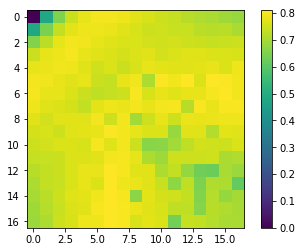

In [33]:
plt.imshow(VarExpls)
plt.colorbar()

print(np.max(VarExpls[0,:]),np.max(VarExpls))



-232545.58


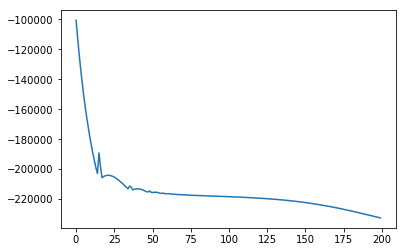

In [13]:
plt.plot(losses)
print(losses[-1])

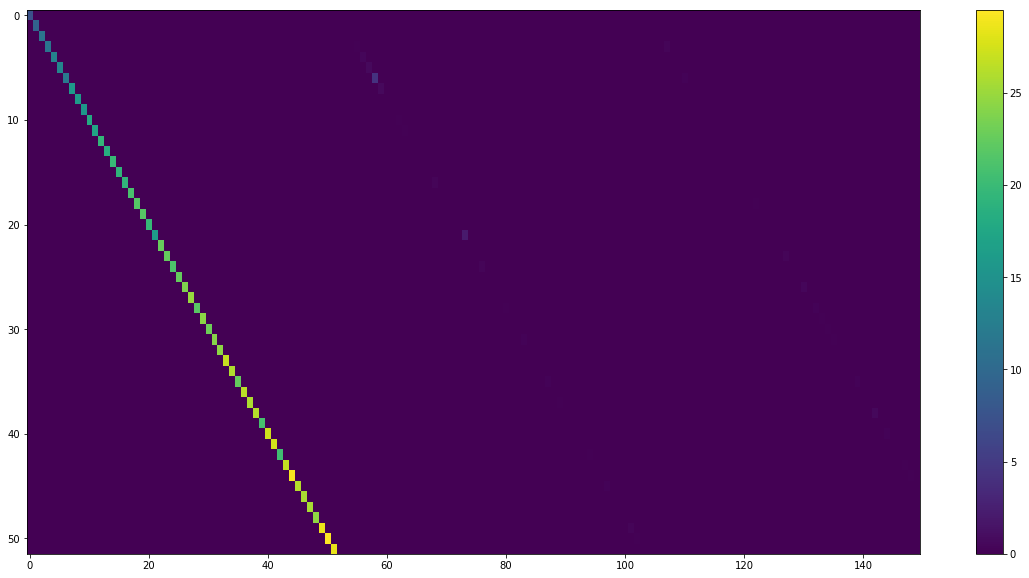

In [14]:
# Check weights
Wm1 =sess.run(_Wm1)
plt.figure(figsize = (20,10))
plt.imshow(Wm1.T**2, aspect='auto')
plt.colorbar()

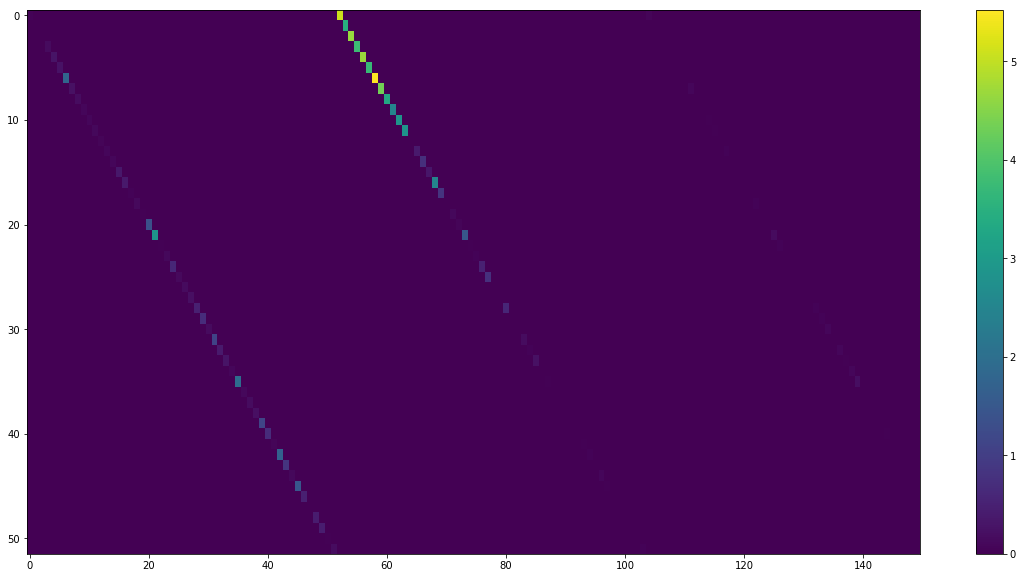

In [15]:
# Check weights
Wm2 =sess.run(_Wm2)
plt.figure(figsize = (20,10))
plt.imshow(Wm2.T**2, aspect='auto')
plt.colorbar()

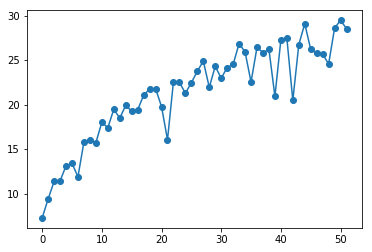

In [16]:
plt.plot(np.diag(Wm1**2),'o-')

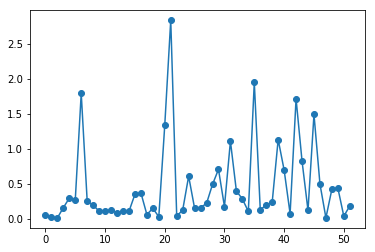

In [17]:
plt.plot(np.diag(Wm2**2),'o-')